In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

In [2]:
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

In [3]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts/"
DATAMAIN_PATH= "/Users/mariavincenzi/PhD/pycoco_2/data/"

#OUTPUT
# - fitted_photometry
#  for each object (1) Table with fitted photometry @spctra MJD
#                  (2) high cadence fitted photometry 
#                  (3) plot of the fit in each band

In [4]:
color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'purple',
                'sdss_g':    'darkgreen','ptf_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'r', "sdss_r'":    'r',
                'sdss_z':    'brown', "sdss_z'":    'brown',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue'}

mark_dict = {'Bessell_U': 'o',
              'Bessell_B': 'o',
                'Bessell_V':  'o',
                'Bessell_R':  'o',
                'Bessell_I':  'o',
                'sdss_g':'s','ptf_g':'s', "sdss_g'":'s',
                'sdss_i':'s', "sdss_i'":'s',
                'sdss_r':'s', "sdss_r'":'s',
                'sdss_z':'s', "sdss_z'":'s',
                'sdss_u': 's', "sdss_u'": 's',
                'Y':  'o','H':  'o', 'J':  'o',
              'Ks':  'o','K':  'o',
                'swift_UVW1':'D',
                'swift_UVW2':'D',
                'swift_UVM2':'D',
                'swift_U':'D',
                'swift_V':'D',
                'swift_B':'D'}

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']

In [5]:
def set_default_kernel_settings(filt):
    if filt not in ['swift_UVW1', 'swift_UVM2','swift_UVW2', 'Bessell_U', 'swift_U']:
        return 150., True, None
    elif filt in ['swift_UVW1', 'swift_UVM2','swift_UVW2', 'Bessell_U', 'swift_U']:
        return 150., False, None


kernel_settings_dict = {
                       'SN1994I':{
                           'Bessell_B':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2007ru':{
                           'Bessell_B':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2008D':{
                           'swift_U':{'scale':5, 'opt':False, 'mean':None},
                           'swfit_B':{'scale':5, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':50, 'opt':False, 'mean':None},
                                   },
                       'SN2002ap':{
                           'Bessell_U':{'scale':30, 'opt':False, 'mean':None},
                                   },
                       'SN2004fe':{
                           'sdss_u':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2009bw':{
                           'swift_UVW2':{'scale':10, 'opt':False, 'mean':None},
                           'Bessell_U':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN1993J':{
                           'Bessell_B':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':500, 'opt':False, 'mean':None},
                                   },
                       'SN1998bw':{
                           'Bessell_U':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':500, 'opt':False, 'mean':None},
                                   },
                       'SN2005cs':{
                           'Bessell_U':{'scale':500, 'opt':True, 'mean':None},
                           'Bessell_B':{'scale':200, 'opt':False, 'mean':1},
                           'Bessell_R':{'scale':500, 'opt':False, 'mean':1},
                           'Bessell_V':{'scale':500, 'opt':False, 'mean':1},
                           'Bessell_I':{'scale':1500, 'opt':False, 'mean':1},
                                   },
                       'SN2012aw':{
                           'Bessell_U':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':1500, 'opt':False, 'mean':0.1},
                           'sdss_g':{'scale':1500, 'opt':False, 'mean':0.1},
                           'sdss_i':{'scale':1500, 'opt':False, 'mean':0.1},
                           'sdss_r':{'scale':1500, 'opt':False, 'mean':0.1},
                           'Bessell_R':{'scale':1500, 'opt':False, 'mean':0.1},
                           'Bessell_V':{'scale':1500, 'opt':False, 'mean':0.1},
                           'Bessell_I':{'scale':2000, 'opt':False, 'mean':0.1},
                           'swift_UVW1':{'scale':10, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':10, 'opt':False, 'mean':None},
                                   },
                       'SN2013fs':{
                           'Bessell_B':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':1500, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':1500, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':600, 'opt':False, 'mean':None},
                           'sdss_r':{'scale':1500, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':40, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':40, 'opt':False, 'mean':None},
                           'swift_UVM2':{'scale':40, 'opt':False, 'mean':None},
                                   },
                       'iPTF13bvn':{
                           'swift_UVW1':{'scale':20, 'opt':True, 'mean':None},
                           'swift_UVW2':{'scale':20, 'opt':False, 'mean':None},
                           'swift_UVM2':{'scale':20, 'opt':True, 'mean':None},
                           'Bessell_U':{'scale':100, 'opt':True, 'mean':None},
                                   },
                       'SN2007pk':{
                           'Bessell_V':{'scale':300, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':300, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':50, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':50, 'opt':False, 'mean':1},
                           'swift_UVM2':{'scale':50, 'opt':False, 'mean':None},
                                   },
                       'SN2007Y':{
                           'sdss_u':{'scale':50, 'opt':False, 'mean':None},
                           'swift_B':{'scale':50, 'opt':False, 'mean':None},
                                   },
                       'SN2007gr':{
                           'Bessell_U':{'scale':50, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':150, 'opt':False, 'mean':None},
                                   },
                       'SN2008bo':{
                           'swift_UVW2':{'scale':20, 'opt':False, 'mean':1.},
                           'swift_UVW1':{'scale':20, 'opt':False, 'mean':1.},
                                   },
                       'SN2008aq':{
                           'swift_UVW2':{'scale':20, 'opt':False, 'mean':1.},
                           'swift_UVW1':{'scale':20, 'opt':False, 'mean':1.},
                                   },
                       'SN2009mg':{
                           'swift_UVW2':{'scale':10, 'opt':False, 'mean':1.},
                           'swift_UVW1':{'scale':10, 'opt':False, 'mean':1.},
                                   },
                       'SN2009iz':{
                           'swift_UVW1':{'scale':10, 'opt':False, 'mean':1.},
                                   },
                       'SN2009N':{
                           'swift_UVW1':{'scale':10, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':10, 'opt':False, 'mean':None},
                                   },
                       'SN2013ab':{
                           'Bessell_V':{'scale':500, 'opt':False, 'mean':None},
                           'sdss_g':{'scale':500, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':500, 'opt':False, 'mean':None},
                                   },
                        'SN2007od':{
                           'Bessell_B':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':1200, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':1200, 'opt':False, 'mean':None},
                                   },
                       'SN2009jf':{
                           'Bessell_B':{'scale':1000, 'opt':False, 'mean':None},
                                   },
                       'SN2006aj':{
                           #'swift_U':{'scale':30, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':500, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':30, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':10, 'opt':False, 'mean':0.3},
                           #'swift_UVM2':{'scale':30, 'opt':False, 'mean':None},
                                   },
                       'SN2011dh':{
                           'Bessell_B':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_U':{'scale':80, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':30, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':30, 'opt':False, 'mean':None},
                           'swift_UVM2':{'scale':30, 'opt':False, 'mean':None},
                                   },
                       'SN2004gq':{
                           'sdss_u':{'scale':70, 'opt':False, 'mean':None},
                                   },
                       'SN2009ip':{
                           'swift_V':{'scale':100, 'opt':False, 'mean':None},
                           'swift_U':{'scale':100, 'opt':False, 'mean':None},
                           'swift_B':{'scale':100, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':100, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':100, 'opt':False, 'mean':None},
                           'swift_UVM2':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2010al':{
                           "Bessell_B":{'scale':120, 'opt':False, 'mean':None},
                           "sdss_u'":{'scale':200, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':50, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':50, 'opt':False, 'mean':None},
                           'swift_UVM2':{'scale':50, 'opt':False, 'mean':None},
                                   },
                       'SN2010alnouv':{
                           "Bessell_B":{'scale':120, 'opt':False, 'mean':None},
                           "sdss_u'":{'scale':200, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':50, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':50, 'opt':False, 'mean':None},
                           'swift_UVM2':{'scale':50, 'opt':False, 'mean':None},
                                   },
                       'SN2011ei':{
                           'swift_B':{'scale':50, 'opt':False, 'mean':1.},
                           'swift_UVW2':{'scale':50, 'opt':False, 'mean':1.},
                           'swift_UVW1':{'scale':50, 'opt':False, 'mean':None},
                                   },
                       'SN2011bm':{
                           "sdss_u'":{'scale':200, 'opt':False, 'mean':None},
                           "sdss_g'":{'scale':200, 'opt':False, 'mean':None},
                           "sdss_z'":{'scale':200, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':200, 'opt':False, 'mean':None},
                                   },
                        'SN1999dn':{
                           'Bessell_B':{'scale':200, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':200, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':200, 'opt':False, 'mean':None},
                                   },
                       'SN2013am':{
                           'swift_UVW2':{'scale':20, 'opt':True, 'mean':None},
                           'swift_UVM2':{'scale':20, 'opt':True, 'mean':None},
                           'swift_UVW1':{'scale':50, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':1000, 'opt':False, 'mean':0.05},
                           'sdss_g':{'scale':1000, 'opt':False, 'mean':0.05},
                           'Bessell_R':{'scale':1000, 'opt':False, 'mean':0.05},
                           'Bessell_I':{'scale':1000, 'opt':False, 'mean':0.05},
                                   },
                        'SN2008in':{
                           'swift_UVW2':{'scale':10, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':10, 'opt':False, 'mean':None},
                                   },
                       'SN2004aw':{
                           'Bessell_U':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2016bkv':{
                           'Bessell_B':{'scale':500, 'opt':False, 'mean':0.05},
                           'Bessell_V':{'scale':1000, 'opt':False, 'mean':0.05},
                           'Bessell_R':{'scale':1000, 'opt':False, 'mean':0.05},
                           'Bessell_I':{'scale':1000, 'opt':False, 'mean':0.05},
                           'sdss_g':{'scale':500, 'opt':False, 'mean':0.05},
                           'sdss_r':{'scale':1500, 'opt':False, 'mean':0.05},
                           'sdss_i':{'scale':1500, 'opt':False, 'mean':0.05},
                           'Bessell_U':{'scale':50, 'opt':False, 'mean':None},
                                   },

                       'SN1999em':{
                           'Bessell_B':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':1000, 'opt':False, 'mean':None},
                                   },
                       'SN2013ej':{
                           'Bessell_U':{'scale':35, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':100, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2012ap':{
                           'swift_UVW1':{'scale':35, 'opt':True, 'mean':None},
                           'swift_U':{'scale':50, 'opt':False, 'mean':None},
                           'swift_B':{'scale':150, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':150, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':150, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':150, 'opt':False, 'mean':None},

                                   },
                        'SN2011ht':{
                           'Bessell_R':{'scale':700, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':700, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':700, 'opt':False, 'mean':None},
                                   },

                       'SN2013df':{
                           'Bessell_R':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_U':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_I':{'scale':1000, 'opt':False, 'mean':None},
                            'swift_V':{'scale':200, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':30, 'opt':True, 'mean':None},
                            'swift_UVW2':{'scale':30, 'opt':True, 'mean':None},
                            'swift_UVM2':{'scale':30, 'opt':True, 'mean':None}
                                   },
                       'SN2013ge':{
                           'swift_UVW2':{'scale':50, 'opt':True, 'mean':None},
                           'swift_UVM2':{'scale':50, 'opt':True, 'mean':None},
                           'swift_UVW1':{'scale':50, 'opt':False, 'mean':None},
                           'swift_U':{'scale':50, 'opt':False, 'mean':None},
                           'swift_B':{'scale':300, 'opt':False, 'mean':None},
                           'swift_V':{'scale':300, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':300, 'opt':False, 'mean':None},
                                   },
                        'SN2013by':{
                           'swift_UVM2':{'scale':500, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':500, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':500, 'opt':False, 'mean':None},
                           'sdss_u':{'scale':50, 'opt':False, 'mean':None},
                           'sdss_g':{'scale':500, 'opt':False, 'mean':None},
                                   },
                        'SN2013bynouv':{
                           'swift_UVM2':{'scale':500, 'opt':False, 'mean':None},
                           'swift_UVW2':{'scale':500, 'opt':False, 'mean':None},
                           'swift_UVW1':{'scale':500, 'opt':False, 'mean':None},
                           'sdss_u':{'scale':50, 'opt':False, 'mean':None},
                           'sdss_g':{'scale':500, 'opt':False, 'mean':None},
                                   },

                       'SN2014G':{
                           'Bessell_U':{'scale':200, 'opt':False, 'mean':None},
                            'swift_UVW1':{'scale':25, 'opt':False, 'mean':None},
                            'swift_UVW2':{'scale':25, 'opt':False, 'mean':None},
                            'swift_UVM2':{'scale':25, 'opt':False, 'mean':None}
                                 },
                       'SN2007ru':{
                           'Bessell_B':{'scale':1200, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':1200, 'opt':False, 'mean':None},
                           'Bessell_R':{'scale':1200, 'opt':False, 'mean':None},
                                   },
                       'SN2008D':{
                           'swift_U':{'scale':30, 'opt':False, 'mean':None},
                           'swfit_B':{'scale':50, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2008bj':{
                           'Bessell_V':{'scale':2000, 'opt':False, 'mean':None},
                           "sdss_r'":{'scale':2000, 'opt':False, 'mean':None},
                           'Bessell_U':{'scale':150, 'opt':False, 'mean':None},
                                   },
                       'SN2009bw':{
                           'swift_UVW2':{'scale':5, 'opt':False, 'mean':None},
                           'Bessell_U':{'scale':1400, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':2000, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':2000, 'opt':False, 'mean':None},
                                   },
                       'SN2009kr':{
                           'swift_UVW2':{'scale':15, 'opt':False, 'mean':None},
                           'Bessell_U':{'scale':300, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':300, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':300, 'opt':False, 'mean':None},
                                   },
                       'SN2007uy':{
                           'swift_UVW2':{'scale':15, 'opt':False, 'mean':0.9},
                                   },
                       'SN2009ib':{
                           "sdss_u'":{'scale':15, 'opt':False, 'mean':None},
                                   },
                       'SN2012A':{
                           'Bessell_U':{'scale':300, 'opt':False, 'mean':None},
                                   },
                       'SN2016X':{
                           'Bessell_U':{'scale':1000, 'opt':False, 'mean':None},
                           'Bessell_B':{'scale':500, 'opt':False, 'mean':None},
                                   },
                       'SN2004gt':{
                           'sdss_u':{'scale':100, 'opt':False, 'mean':None},
                                   },
                       'SN2009bb':{
                           'sdss_u':{'scale':50, 'opt':False, 'mean':None},
                                   },
                       'ASASSN15no':{
                           'sdss_u':{'scale':5000, 'opt':False, 'mean':None},
                                   },
                       'ASASSN14jb':{
                           'Bessell_B':{'scale':2000, 'opt':False, 'mean':None},
                           'Bessell_V':{'scale':10000, 'opt':False, 'mean':None},
                                   }    
                        }

In [6]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux



In [21]:
class SNPhotometryClass():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, main_path, lc_path, snname, verbose=False):
        """
        """

        ## Initialise the class variables
        self.main_path = main_path
        self.lc_data_path = lc_path+'/'
        #self.lc_data_path = '/Users/mariavincenzi/PhD/pycoco_2/data/lc/'

        self.spec_data_path = main_path+'/spec/'
        self.snname = snname   
        self.set_data_directory(verbose)

    def set_data_directory(self, verbose):
        """
        Set a new data directory path.
        Enables the data directory to be changed by the user.
        """
        SNphotometry_PATH = os.path.join(self.lc_data_path, '%s.dat'%self.snname)
        
        try:
            if verbose: print('Looking for Photometry for %s in%s'%(self.snname, SNphotometry_PATH))
            if os.path.isfile(SNphotometry_PATH):
                if verbose: print ('Got it!')
                self.sn_rawphot_file = SNphotometry_PATH
                pass
            else:
                if not os.path.isdir(self.lc_data_path):
                    print ('I cant find the directory with photometry. Check %s'%self.lc_data_path)
                    pass
                else: 
                    print ('I cant find the file with photometry. Check %s'%SNphotometry_PATH)
                    pass
    
        except Exception as e:
            print (e)

    def load(self, verbose = False):
        """
        Loads a single photometry file.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        if verbose: print('Loading %s'%self.sn_rawphot_file)
        try:
            lc_file = np.genfromtxt(self.sn_rawphot_file,
                                    names=['MJD','filter','flux','flux_err','FilterSet'], usecols=[0,1,2,3,4], 
                                    dtype=None,encoding="utf-8")

            mask_filt = np.array([f not in exclude_filt for f in lc_file['filter']])
            lc_no_badfilters = lc_file[mask_filt]
            mask_filt = np.array([~np.isnan(f) for f in lc_no_badfilters['flux']])
            self.phot = lc_no_badfilters[mask_filt]
            
            #filtname_filtset = [fn+'__'+fs for fn,fs in zip(self.phot['filter'], self.phot['FilterSet'])]
            self.avail_filters = np.unique(self.phot['filter'])

            self.phot_extended = self.phot
            print ('Photometry loaded')

            
        except Exception as e:
            print (e)
            print ('Are you sure you gave me the right format? Check documentation in case.')

    def get_availfilter(self, verbose = False):
        """
        get available filter for this SN
        """
        #if photometry is not already loaded, load it!
        if (not hasattr(self, "phot"))|(not hasattr(self, "avail_filters")):
            self.load()
        return self.avail_filters
        
    def get_singlefilter(self, single_filter, extended_clipped = False, verbose = False):
        """
        Loads from photometry file just 1 filter photometry.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not (isinstance(single_filter, str)):
            print ('Single filter string please')
            return None
        
        if single_filter not in self.avail_filters:
            print ('Looks like the filter you are looking for is not available')
            return None
        
        if extended_clipped:
            if not hasattr(self, "phot_extended"):
                self.extend_photometry()
            filt_index = self.phot_extended['filter']==single_filter
            return self.phot_extended[filt_index] 
        else: 
            filt_index = self.phot['filter']==single_filter
            return self.phot[filt_index]
        
    
    def get_mjdpeak(self, verbose = False):
        """
        Loads from photometry for each filter, measure peak for each filter
        get a rough estimate of the paek_mjd
        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
            
        mjd_peaks_list=[]
        for f in self.avail_filters:
            phot_perfilt = self.get_singlefilter(f)
            mjd_peak = phot_perfilt['MJD'][np.argmax(phot_perfilt['flux'])]
            mjd_peaks_list.append(mjd_peak)
            
        return np.min(mjd_peaks_list)
    
    def extend_photometry(self, before_peak=30., after_peak=500., verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not hasattr(self, "clipped_phot"):
            self.clip_photometry()
        
        mjd_peak = self.get_mjdpeak()
        LC = self.clipped_phot
        
        filt_avail = self.avail_filters

        mjd_ext_early = min((mjd_peak - before_peak), min(LC['MJD']))
        before_peak = mjd_peak - mjd_ext_early -5.

        mjd_ext_latly = (mjd_peak + after_peak)
        
        LC_extended = LC
        
        for filt in filt_avail:
            LC_xfilter = LC[LC['filter']==filt]
            
            ## flux estimate
            ## decline due to radioactive decay:
            ## log10(flux[erg/cm2/A/s]) = -0.0065*(mjds_after_peak)-15.5
            #logflux_late = -0.0065*(after_peak)-17.5
            #flux_ext_latly = 10**(logflux_late)
            #flux_ext_early = 10**(logflux_late)#less physical but still reasonable
        
            #estimate_error = np.max(LC_xfilter['flux_err'][:5])
            #flux_err_ext_early = estimate_error
            #flux_err_ext_latly = estimate_error
        
            #ext_early = np.array([(mjd_ext_early, flux_ext_early, flux_err_ext_early, filt)], LC.dtype)
            #ext_latly = np.array([(mjd_ext_latly, flux_ext_latly, flux_err_ext_latly, filt)], LC.dtype)
    
            ##if theres no point before -10 extend before peak
            ## or the first point is :
            #need_anchoring = self.get_anchoring(filt)
            #no_need_extention_before = need_anchoring[0]=='n'
            ##((min(LC_xfilter['MJD'])-mjd_peak)<-before_peak)|\
            ##       (max(LC_xfilter['flux'])/LC_xfilter['flux'][0]>5.) 
            ##if theres a point at more than 60 don't extend before peak:
            #no_need_extention_after = need_anchoring[1]=='n'
            ##(max(LC_xfilter['MJD'])-mjd_peak)>60. 

            #if (no_need_extention_before)&(no_need_extention_after):
            #    pass
            #elif (no_need_extention_before)&(not no_need_extention_after):
            #    LC_extended = np.concatenate((LC_extended, ext_latly))
            #elif (not no_need_extention_before)&(no_need_extention_after):
            #    LC_extended = np.concatenate((ext_early, LC_extended))
            #elif (not no_need_extention_before)&(not no_need_extention_after):
            #    LC_extended = np.concatenate((ext_early, LC_extended, ext_latly))
        #print 'Compare lenghts', len(LC), len(LC_extended)
        self.phot_extended = self.clipped_phot
        return self.clipped_phot

    def plot_raw_phot(self, filt_list=None, plt_extended_clipped=False, save_fig=False, \
                      save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        if (plt_extended_clipped)&(not hasattr(self, "phot_extended")):
            self.extend_photometry()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f, extended_clipped=plt_extended_clipped)
            plt.errorbar(phot_f['MJD'], phot_f['flux'], phot_f['flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None

    def plot_GP_fit_phot(self, filt_list=None, save_fig=False, save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        if not hasattr(self, "gp"):
            self.load()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f)
            plt.errorbar(phot_f['MJD'], phot_f['flux'], yerr=phot_f['flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None



    def clip_LC_filter(self, filter_name, clipping_mjd_delta = 0.5):
        
        def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, instr_unclipped, clipping_index):
            mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
            flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
            flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
            mjd_avg = np.average(mjd_tbc)
            flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
            flux_err_avg = max([np.std(flux_tbc), np.sqrt(1./sum_w)])
            clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
            clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
            clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
            clipped_instr_sorted = np.delete(instr_unclipped, clipping_index)
            clipped_mjd_sorted[clipping_index] = mjd_avg
            clipped_flux_sorted[clipping_index] = flux_avg
            clipped_flux_err_sorted[clipping_index] = flux_err_avg
            #print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
            return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted, clipped_instr_sorted
    
        LC_filt = self.get_singlefilter(filter_name)
        mjd_sorted = np.sort(LC_filt['MJD'])
        flux_sorted = LC_filt['flux'][np.argsort(LC_filt['MJD'])]
        flux_err_sorted = LC_filt['flux_err'][np.argsort(LC_filt['MJD'])]
        instr_sorted = LC_filt['FilterSet'][np.argsort(LC_filt['MJD'])]

        new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted]) 
        double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
        new_flux_sorted = np.copy(flux_sorted)
        new_flux_err_sorted = np.copy(flux_err_sorted)
        new_Instr_sorted = np.copy(instr_sorted)
        
        #while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
        #    tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
        #    Res = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, tbc_indexes[0])
        #    new_mjd_sorted, new_flux_sorted, new_flux_err_sorted = Res

        while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
            tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
            ind = tbc_indexes[0]
            R = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted, ind)
            new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted= R
        new_filter_sorted = np.full(len(new_mjd_sorted), filter_name, dtype='|S20')
        new_LC=[]
        for i in zip(new_mjd_sorted, new_filter_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted):
            new_LC.append(i)
        new_LC = np.array(new_LC, LC_filt.dtype)
        
        print (filter_name, 'Before clipping %i, after %i'%(len(mjd_sorted), len(new_LC)))
        return new_LC
    
    def clip_photometry(self, verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        filt_avail = self.avail_filters
        
        clipping_mjd_delta = 0.2
        LC_clipped = np.array([], self.phot.dtype) 
        for ff in filt_avail:
            LC_xfilter = self.clip_LC_filter(ff, clipping_mjd_delta)
            LC_clipped = np.concatenate([LC_clipped, LC_xfilter])
        self.clipped_phot = LC_clipped
        return None
    
    def get_spec_mjd(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            return parse_phase['f0']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_spec_list(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None,encoding="utf-8")
            return parse_phase['f2']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_noise_level(self):
        if not hasattr(self, "avail_filters"):
            self.load()
        default_wn_noise_dict = dict(zip(self.avail_filters, np.array(['10e-5' for i in self.avail_filters])))
        white_noise_file = np.genfromtxt(self.lc_data_path+'white_noise_level_file.dat',\
                                         comments='#', names=True, dtype=None, encoding="utf-8")
        if self.snname not in white_noise_file['snname']:
            return default_wn_noise_dict
        else:
            tuned_values = white_noise_file[white_noise_file['snname']==self.snname]
            wn_noise_dict = dict(zip(tuned_values['filt'], (tuned_values['noise'])))
            return wn_noise_dict
    
    def get_anchoring(self, filt):
        if not hasattr(self, "avail_filters"):
            self.load()
        default_anchor_before = 'n'
        default_anchor_after = 'n'

        anchoring_file = np.genfromtxt(self.lc_data_path+'white_noise_level_file.dat',\
                                         comments='#', names=True, dtype=None, encoding="utf-8")
        if self.snname not in anchoring_file['snname']:
            return default_anchor_before, default_anchor_after
        else:
            tuned_values = anchoring_file[(anchoring_file['snname']==self.snname)&(anchoring_file['filt']==filt)]
            return tuned_values['anchor_before'], tuned_values['anchor_after']
        
    def LCfit_withGP_xfilter(self, filt, minMJD=None, maxMJD=None):
        if not hasattr(self, "phot"):
            self.load()

        def ll(p):
            gp.set_parameter_vector(p)
            return -gp.lnlikelihood(flux_norm, quiet=False)#

        # gradient of the  liklihood for optimisation of the kernel size

        def grad_ll(p):
            gp.set_parameter_vector(p)
            return -gp.grad_lnlikelihood(flux_norm, quiet=False)
        
        A = self.extend_photometry()
                
        mjd_peak = self.get_mjdpeak()
        
        mjd_spectra = self.get_spec_mjd()
        if minMJD is None:
            #minMJD= min([mjd_peak-15.,np.min(self.phot_extended['MJD'])])  #np.min(self.phot_extended['MJD'])
            minMJD= min([min(mjd_spectra),np.min(self.phot_extended['MJD'])])  #np.min(self.phot_extended['MJD'])
        if maxMJD is None:
            #maxMJD= min([max(mjd_spectra),np.max(self.phot['MJD'])])
            maxMJD= min([minMJD+300.,np.max(self.phot['MJD'])])
        
        print ('MJD range', maxMJD-minMJD)
        #if self.snname=='iPTF13bvn': new_mjd = np.arange(minMJD, maxMJD, 0.01)
        new_mjd = np.arange(minMJD-1., maxMJD+1., 0.05)

        LC_filt_extended = self.get_singlefilter(filt, extended_clipped=True)
        mjd = LC_filt_extended['MJD']
        mjdT = np.atleast_2d(mjd).T
        
        orig_flux = (LC_filt_extended['flux'])
        orig_flux_err = LC_filt_extended['flux_err']

        if TRY_LOG:
            flux_gp = np.log(LC_filt_extended['flux'])
            flux_err_gp = LC_filt_extended['flux_err']/LC_filt_extended['flux']
        else:
            flux_gp = (LC_filt_extended['flux'])
            flux_err_gp = LC_filt_extended['flux_err']

        norm = np.median(flux_gp) #np.median(LC_filt_extended['flux']) 
        flux_norm = flux_gp/norm
        err_flux_norm = flux_err_gp/norm
                        
        #wn_noise_dict = self.get_noise_level()
        #wn_level= np.log(eval(wn_noise_dict[filt]))
        #gp = george.GP(k, white_noise=wn_level, fit_white_noise=False)
        
        if (self.snname in list(kernel_settings_dict.keys())):
            if filt in list(kernel_settings_dict[self.snname].keys()):
                set_scale = kernel_settings_dict[self.snname][filt]['scale']
                set_optimization = kernel_settings_dict[self.snname][filt]['opt']
                set_mean = kernel_settings_dict[self.snname][filt]['mean']
            else:
                set_scale, set_optimization, set_mean = set_default_kernel_settings(filt)
        else:
            set_scale, set_optimization, set_mean = set_default_kernel_settings(filt)
        if set_mean: set_fit_mean = True
        else: set_fit_mean=False
            
        k= np.var(flux_norm)* Matern32Kernel(set_scale)
        gp = george.GP(k, mean=set_mean, fit_mean=set_fit_mean)#, white_noise=10**-5, fit_white_noise=True)
        gp.compute(mjdT, err_flux_norm)
        if set_optimization:
            p0=gp.get_parameter_vector()
            results = opt.minimize(ll, p0, jac=grad_ll)
        print ('results ',filt, np.exp(gp.get_parameter_vector()))
        mu_gp, cov = gp.predict(flux_norm, new_mjd)
        std_gp = np.sqrt(np.diag(cov))
        
        if TRY_LOG:
            mu = np.exp(mu_gp*norm)
            std =  np.abs(mu*std_gp*norm)
        else:
            mu = mu_gp*norm
            std =  std_gp*norm

        mu_mjdspec, cov_mjdspec = gp.predict(flux_norm, mjd_spectra)
        std_mjdspec = np.sqrt(np.diag(cov_mjdspec))
        mu_mjdspec = (mu_mjdspec*norm)
        std_mjdspec =(std_mjdspec*norm)
        
        self.fitted_phot[filt] = {'clipped_extended_data': [mjd, orig_flux, orig_flux_err],
                                  'fit_highcadence':  [new_mjd, mu, std],
                                 'fit_mjdspec':  [mjd_spectra, mu_mjdspec, std_mjdspec]}
        return None


    def LCfit_withGP(self, minMJD=None, maxMJD=None):
        if not hasattr(self, "phot"):
            self.load()

        if not hasattr(self, "fitted_phot"):
            print ('Computing GP fit (for the first time)')
            self.fitted_phot = dict(zip(self.avail_filters, np.zeros(len(self.avail_filters))))
        else:
            print ('Forcing to do GP fit again')
            self.fitted_phot = dict(zip(self.avail_filters, np.zeros(len(self.avail_filters))))
        
        for f in self.avail_filters:
            self.LCfit_withGP_xfilter(f, minMJD=minMJD, maxMJD=maxMJD)
        return None
        
        
    def save_plot_GPfit(self, save_fig_output=None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")


        max_flux = [10**-20]
        fig = plt.figure(figsize=(14,6))
        #plt.rc('font', family='serif')
        plt.rc('font', family='serif')
        #plt.rc('text', usetex=True)
        plt.rc('xtick', labelsize=13)
        plt.rc('ytick', labelsize=13)
        #plt.rc('axes', labelsize=13)
        #plt.rc('xtick', labelsize='small')
        #plt.rc('ytick', labelsize='small')
        for f in self.avail_filters:
            c = color_dict[f]
            mjd, flux, err_flux = self.fitted_phot[f]['clipped_extended_data'] 
            new_mjd, mu, std= self.fitted_phot[f]['fit_highcadence'] 

            if 'swift' in f: flabel = f.split('_')[1]+'(Swift)'
            else: flabel = f.split('_')[1]
            a=plt.errorbar(mjd, flux, yerr=err_flux, fmt=mark_dict[f], 
                           mfc= c, ms =5, color= c,linestyle='None', label=flabel)
            plt.plot(new_mjd, mu, color=a[0].get_color())#, label=flabel)
            plt.fill_between(new_mjd, (mu+std), (mu-std), color=a[0].get_color(), alpha=0.1)
            max_flux.append(max(flux))
        
        #plt.hlines(0, min(new_mjd)-7., max(new_mjd))
        plt.vlines(self.get_spec_mjd(), max(max_flux)*0.95, max(max_flux)*1.085, lw=0.8,
                   linestyle='-', color='k', label='Spectra')
        try:
            plt.xlim(min(self.phot_extended['MJD'])-3., max(self.get_spec_mjd())+30.)
        except:
            plt.xlim(min(self.phot_extended['MJD'])-3., max(self.phot_extended['MJD'])+30.)

        plt.xlabel(r'Time (MJD)', fontsize=13)
        plt.ylabel(r'Flux ($\mathrm{erg}$ $\mathrm{s^{-1} cm^{-2}} \mathrm{\AA} $)', fontsize=13)
        plt.ylim(-0.01*max(max_flux), max(max_flux)*1.1)
        plt.xlim(min(self.phot_extended['MJD'])-3.,min(self.phot_extended['MJD'])+65)
        plt.legend(fontsize=13, ncol=2, loc='center right', fancybox=True, framealpha=0.5)
        plt.title(self.snname+' light curve fitting using Gaussian Processes', fontsize=15)
        if save_fig_output is None:
            #width  = 3.487
            #height = width / 1.618
            #fig.set_size_inches(width, height)
            fig.savefig(self.results_mainpath+'fittedGP_%s_.pdf'%self.snname, bbox_inches='tight')
        else:
            fig.savefig(save_fig_output, bbox_inches='tight')
        return None
    
    def save_plot_GPfit_spec(self, save_fig_output=None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.""")
        fig = plt.figure(figsize=(9,4))
        max_flux=[];min_flux=[]
        for f in self.avail_filters:
            c = color_dict[f]
            hc_mjd, hc_mu, hc_std = self.fitted_phot[f]['fit_highcadence'] 
            new_mjd, mu, std= self.fitted_phot[f]['fit_mjdspec'] 
            a=plt.errorbar(new_mjd, mu, yerr=std, fmt=mark_dict[f], 
                           mfc= c, ms =4, elinewidth=0.8, color= c,linestyle='None')
            plt.plot(hc_mjd, hc_mu, color=a[0].get_color(), label=f, alpha=0.3)
            max_flux.append(max(hc_mu[~np.isnan(hc_mu)])); min_flux.append(min(hc_mu[~np.isnan(hc_mu)]))
        if len(new_mjd)==0: new_mjd, mu, std= self.fitted_phot[f]['clipped_extended_data'] 
        plt.xlim(min(self.phot_extended['MJD'])-4., min(self.phot_extended['MJD'])+200.)
        #plt.legend(fontsize=13, ncol=2, loc='center right', fancybox=True, framealpha=0.5)
        plt.ylim(min(np.abs(min_flux)), max(max_flux))
        plt.yscale('log')
        plt.title(self.snname+' fitted photometry for mangling')
        if save_fig_output is None:
            fig.savefig(self.results_mainpath+'fittedGPspec_%s_.pdf'%self.snname, bbox_inches='tight')
        else:
            fig.savefig(save_fig_output,bbox_inches='tight')
        return None
        

    def mangling_GPfile(self, name_file = None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")
            
        fit_result2mangling = pd.DataFrame()
        fit_result2mangling['spec_file'] = self.get_spec_list()
        fit_result2mangling['spec_mjd'] = self.get_spec_mjd()

        for f in self.avail_filters:
            minmjd = int(min(self.get_singlefilter(f, extended_clipped=False)['MJD'])-1)
            maxmjd = int(max(self.get_singlefilter(f, extended_clipped=False)['MJD'])+1)
            mjd, flux, err_flux = self.fitted_phot[f]['fit_mjdspec'] 
            inrange = np.array([ (int(m)>= minmjd)&(int(m)<= maxmjd) for m in mjd])
            fit_result2mangling[f+'_fitflux'] = flux
            fit_result2mangling[f+'_fitfluxerr'] = err_flux
            fit_result2mangling[f+'_inrange'] = inrange
        
        fit_result2mangling.to_csv(self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname,\
                                  sep='\t', index=False)
        return fit_result2mangling

    def full_fitted_LC_file(self, name_file = None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")
        
        df = pd.DataFrame()
        mjds = self.fitted_phot[self.avail_filters[0]]['fit_highcadence'][0]
        df['MJD'] = mjds
        
        for i in self.avail_filters:
            lc_filt = self.get_singlefilter(i)
            min_mjd = min(lc_filt['MJD'])
            max_mjd = max(lc_filt['MJD'])
            flux = self.fitted_phot[i]['fit_highcadence'][1]
            flux_err = self.fitted_phot[i]['fit_highcadence'][2]
            mask_out = (mjds<min_mjd)|(mjds>max_mjd)
            flux[mask_out] = np.nan
            flux_err[mask_out] = np.nan
            df[i] = flux
            df[i+'_err'] = flux_err
        
        df.to_csv(self.results_mainpath+'fitted_phot_%s.dat'%self.snname,\
                                  sep='\t', index=False,na_rep='nan')

        return df
    
    def create_results_folder(self):
        results_directory = self.main_path+'/results_template/%s/'%self.snname
        if not os.path.exists(results_directory):
            os.makedirs(results_directory)
        self.results_mainpath = results_directory


In [22]:
TRY_LOG=False

In [23]:
prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname='iPTF13bvn', verbose=True)


Looking for Photometry for iPTF13bvn in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts//iPTF13bvn.dat
Got it!


In [24]:
prova2.load()
prova2.get_availfilter()
prova2.clip_photometry()

Photometry loaded
Bessell_B Before clipping 217, after 210
Bessell_I Before clipping 254, after 243
Bessell_R Before clipping 253, after 242
Bessell_U Before clipping 11, after 11
Bessell_V Before clipping 217, after 209
sdss_g' Before clipping 315, after 259
sdss_i' Before clipping 312, after 253
sdss_r' Before clipping 333, after 255
sdss_z' Before clipping 33, after 32
swift_B Before clipping 7, after 7
swift_U Before clipping 8, after 8
swift_UVW1 Before clipping 6, after 6
swift_UVW2 Before clipping 4, after 4
swift_V Before clipping 6, after 6


In [25]:
prova2.LCfit_withGP()
df = prova2.full_fitted_LC_file()

Computing GP fit (for the first time)
MJD range 300.0
results  Bessell_B [ 123.01502162 2098.42517998]
MJD range 300.0
results  Bessell_I [ 1699.19094491 51428.71987816]
MJD range 300.0
results  Bessell_R [ 10810.93393901 104161.9111136 ]
MJD range 300.0
results  Bessell_U [ 14.31446965 128.35509896]
MJD range 300.0
results  Bessell_V [ 239.41708211 6604.66123817]
MJD range 300.0
results  sdss_g' [ 440.01394094 5487.14702393]
MJD range 300.0
results  sdss_i' [  243.29403649 11589.96340042]
MJD range 300.0
results  sdss_r' [ 2011.39472645 27670.47019807]
MJD range 300.0
results  sdss_z' [   1.58575694 1026.19434651]
MJD range 300.0
results  swift_B [  1.06251999 308.57896421]
MJD range 300.0
results  swift_U [  0.84292976 150.        ]
MJD range 300.0
results  swift_UVW1 [  1.27813849 107.94417866]
MJD range 300.0
results  swift_UVW2 [ 0.04712132 20.        ]
MJD range 300.0
results  swift_V [  0.5681609  409.05685696]
LC fit already done. I will use the one that it.s available.
If you 

In [26]:
def print_separate(prova2):
    folder = prova2.results_mainpath+'GPfits/'
    if not os.path.exists(folder):
        os.makedirs(folder)

    for f in prova2.avail_filters:
        fig = plt.figure(figsize=(10,3))
        c = color_dict[f]
        mjd, flux, err_flux = prova2.fitted_phot[f]['clipped_extended_data'] 
        new_mjd, mu, std= prova2.fitted_phot[f]['fit_highcadence'] 
        a=plt.errorbar(mjd, flux, yerr=err_flux, fmt='.', mfc= c, \
                   elinewidth=0.8, color= c,linestyle='None', alpha=0.5)
        plt.plot(new_mjd, mu, color=a[0].get_color(), lw=0.4,  label=f)
        plt.fill_between(new_mjd, (mu+std), (mu-std), color=a[0].get_color(), alpha=0.4)
        plt.vlines(prova2.get_spec_mjd(), min(flux)*0.9, 1.1*max(flux), linestyle=':', lw=0.3)
        plt.legend()
        fig.savefig(folder+f+'.pdf')
        plt.close(fig)



LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.
LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.
LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


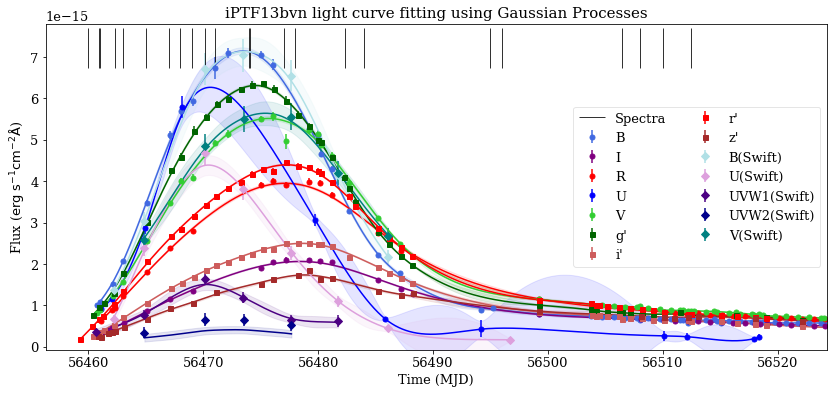

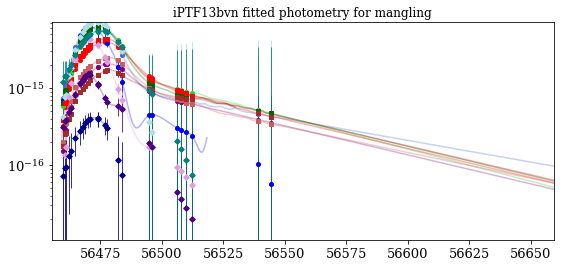

In [27]:
#prova2 = SNPhotometryClass(main_path=DATALC_PATH, snname='SN2002ap', verbose=True)
cvs_file=prova2.mangling_GPfile()
prova2.save_plot_GPfit()
prova2.save_plot_GPfit_spec()
print_separate(prova2)

In [34]:
print_separate(prova2)

In [13]:
sn_list=['SN1993J', 'SN1994I', 'SN1998bw', 'SN1999dn',
       'SN2002ap', 'SN2004aw', 'SN2004fe', 'SN2005bf',
       'SN2005hg', 'SN2006aj', 'SN2007Y',
       'SN2007gr', 'SN2007uy', 'SN2008D', 'SN2008ax', 'SN2008bo',
       'SN2009bb', 'SN2009er', 'SN2009iz', 'SN2009jf', 'SN2010al',
       'SN2011bm', 'SN2011dh', 'SN2011ei', 'SN2011fu', 'SN2012ap',
       'SN2013ge', 'iPTF13bvn', 'SN2005cs', 'SN2007pk',
       'SN2008aq', 'SN2008fq', 'SN2009dd',
       'SN2010al', 'SN2011hs', 'SN2013am',
       'SN2013ej', 'SN2013df', 'SN2013fs', 'SN2014G', 'SN2006jc',
       'SN2008bj', 'SN2007ru', 'SN2009ip', 'SN2011fe', 'SN2013ab',
       'SN2012aw', 'SN2009N', 'SN1999em', 'SN2009bw', 'SN2004et',
       'SN2013by', 'SN2016gkg', 'SN2016X', 'SN2007od', 'SN2006bp',
       'SN2008in', 'SN2009ib', 'SN2012A', 'SN2006T', 'SN2004gq',
       'SN2013hj', 'SN2004gt', 'SN2004gv', 'SN2006ep', 'SN2006aa',
       'SN2011ht', 'SN2012au', 'SN2016bkv', 'SN2011ht',
       'SN2009kr', 'ASASSN15no', 'ASASSN15oz', 'ASASSN14jb', 'SN2009ib', 
         'SN2013bynouv', 'iPTF13bvnnouv']

Looking for Photometry for SN2012au in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts//SN2012au.dat
Got it!
Photometry loaded
Bessell_B Before clipping 37, after 37
Bessell_I Before clipping 199, after 176
Bessell_R Before clipping 205, after 176
Bessell_V Before clipping 201, after 176
sdss_z Before clipping 195, after 177
swift_B Before clipping 12, after 12
swift_U Before clipping 12, after 12
swift_UVM2 Before clipping 12, after 12
swift_UVW1 Before clipping 11, after 11
swift_UVW2 Before clipping 12, after 12
swift_V Before clipping 12, after 12
Computing GP fit (for the first time)
MJD range 205.0
results  Bessell_B [  12.45486385 1116.62333348]
MJD range 205.0
results  Bessell_I [  12.72064276 9399.07206157]
MJD range 205.0
results  Bessell_R [  21.45928519 8004.02174811]
MJD range 205.0
results  Bessell_V [  25.72966141 5477.17665344]
MJD range 205.0
results  sdss_z [  41.36512701 8704.13113509]
MJD range 205.0
results  swift_B [1.16417835e+00 1.22202

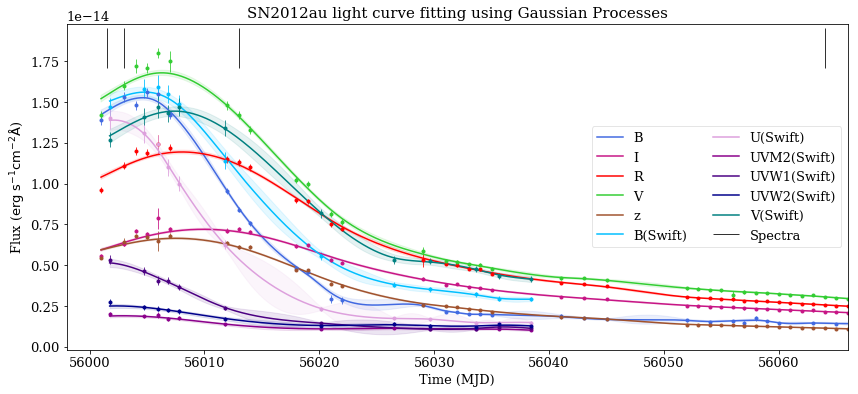

LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


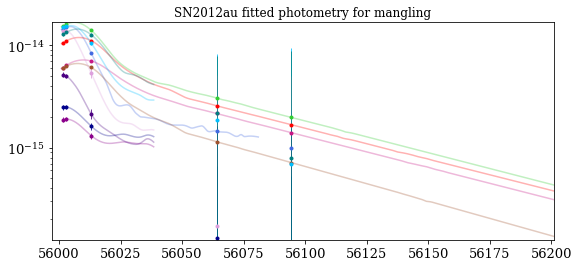

Looking for Photometry for iPTF13bvn in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts//iPTF13bvn.dat
Got it!
Photometry loaded
Bessell_B Before clipping 45, after 39
Bessell_I Before clipping 254, after 243
Bessell_R Before clipping 253, after 242
Bessell_U Before clipping 11, after 11
Bessell_V Before clipping 217, after 209
sdss_g' Before clipping 315, after 259
sdss_i' Before clipping 312, after 253
sdss_r' Before clipping 333, after 255
sdss_z' Before clipping 33, after 32
swift_B Before clipping 7, after 7
swift_U Before clipping 8, after 8
swift_UVW1 Before clipping 6, after 6
swift_UVW2 Before clipping 4, after 4
swift_V Before clipping 6, after 6
Computing GP fit (for the first time)
MJD range 300.0
results  Bessell_B [  9.44611523 478.64642703]
MJD range 300.0
results  Bessell_I [ 1699.19094491 51428.71987816]
MJD range 300.0
results  Bessell_R [ 10810.93393901 104161.9111136 ]
MJD range 300.0
results  Bessell_U [ 14.31446965 128.35509896]
MJD range

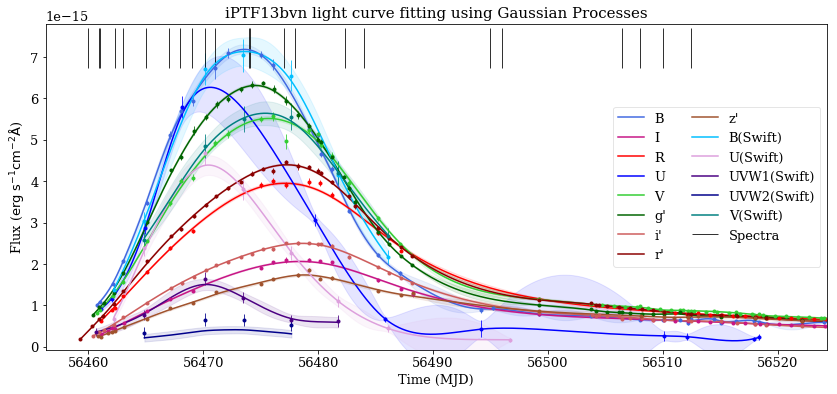

LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


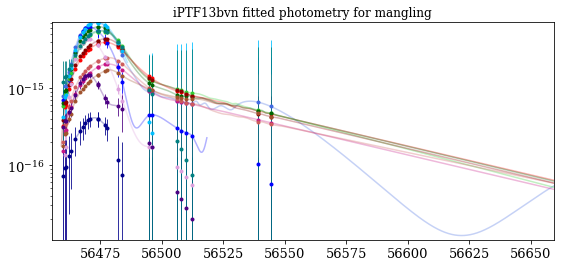

Looking for Photometry for SN2013am in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts//SN2013am.dat
Got it!
Photometry loaded
Bessell_B Before clipping 14, after 14
Bessell_I Before clipping 22, after 22
Bessell_R Before clipping 18, after 18
Bessell_U Before clipping 7, after 7
Bessell_V Before clipping 21, after 21
sdss_i Before clipping 12, after 12
Computing GP fit (for the first time)
MJD range 300.0
results  Bessell_B [2.63579576e+00 1.19673086e+04]
MJD range 300.0
results  Bessell_I [1.05127110e+00 2.18965496e-01 1.00000000e+03]
MJD range 300.0
results  Bessell_R [1.05127110e+00 2.42633389e-01 1.00000000e+03]
MJD range 300.0
results  Bessell_U [1.00284882e-01 1.50000000e+02]
MJD range 300.0
results  Bessell_V [1.05127110e+00 2.11947953e-01 1.00000000e+03]
MJD range 300.0
results  sdss_i [6.02346016e-01 6.26191087e+03]
LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() ag

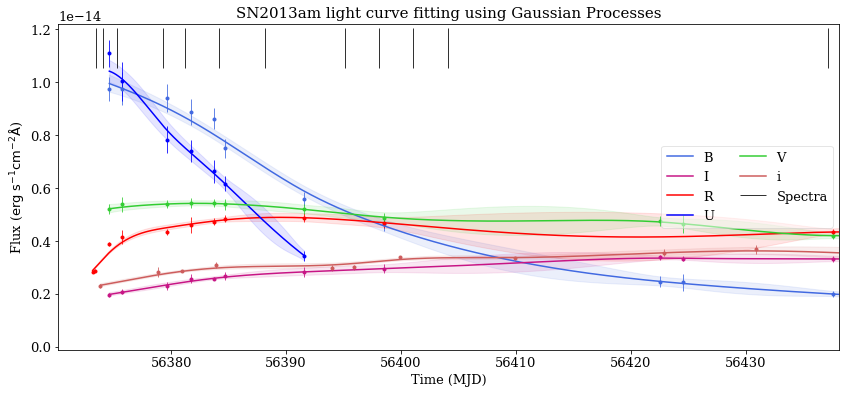

LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.


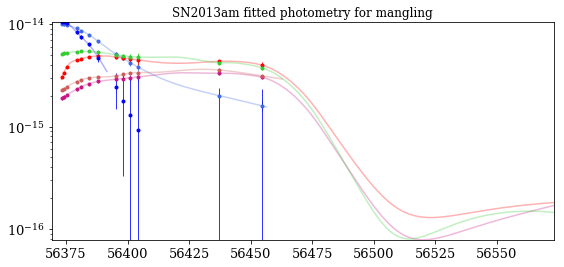

Looking for Photometry for SN2011ei in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts//SN2011ei.dat
Got it!
Photometry loaded
Bessell_B Before clipping 9, after 9
Bessell_I Before clipping 10, after 10
Bessell_R Before clipping 11, after 11
Bessell_V Before clipping 129, after 126
swift_B Before clipping 21, after 21
swift_U Before clipping 14, after 14
swift_UVW1 Before clipping 9, after 9
swift_UVW2 Before clipping 5, after 5
swift_V Before clipping 21, after 21
Computing GP fit (for the first time)
MJD range 149.00999999999476
results  Bessell_B [  1.8374592 427.5010555]
MJD range 149.00999999999476
results  Bessell_I [5.46420513e-01 1.58884546e+03]
MJD range 149.00999999999476
results  Bessell_R [5.41063119e-01 1.52668081e+03]
MJD range 149.00999999999476
results  Bessell_V [   9.60940743 1599.36425425]
MJD range 149.00999999999476
results  swift_B [ 2.71828183  0.30419234 50.        ]
MJD range 149.00999999999476
results  swift_U [  0.23532175 150.      

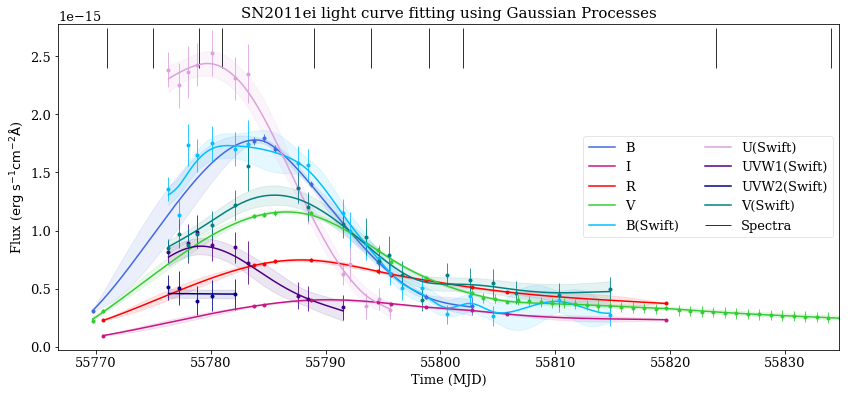

LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.


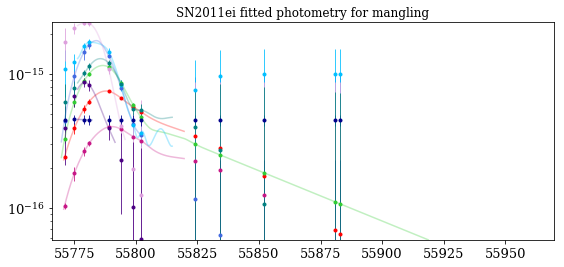

Looking for Photometry for SN2002ap in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts//SN2002ap.dat
Got it!
Photometry loaded
Bessell_B Before clipping 40, after 34
Bessell_I Before clipping 217, after 204
Bessell_R Before clipping 213, after 200
Bessell_U Before clipping 10, after 9
Bessell_V Before clipping 520, after 202
Computing GP fit (for the first time)
MJD range 211.87999999999738
results  Bessell_B [  5.28920896 750.44845487]
MJD range 211.87999999999738
results  Bessell_I [ 1062.00579764 89770.52955617]
MJD range 211.87999999999738
results  Bessell_R [  799.77438792 38030.09389711]
MJD range 211.87999999999738
results  Bessell_U [ 2.24511007 30.        ]
MJD range 211.87999999999738
results  Bessell_V [  920.80621252 22228.56788135]
LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.
LC fit already done. I will use the one that it.s available.
If you want to do

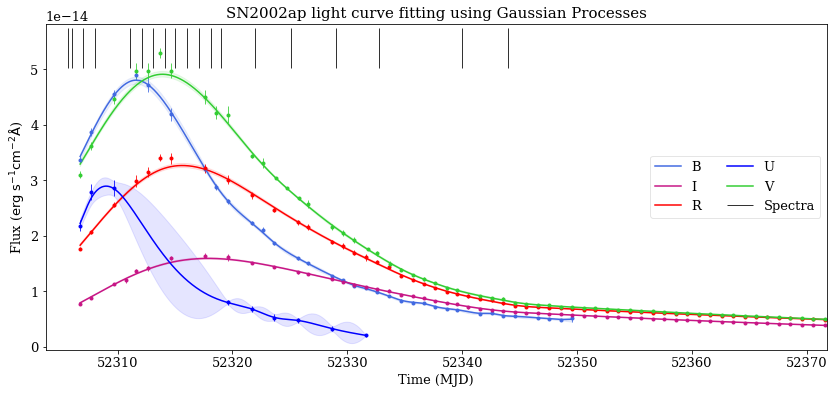

LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


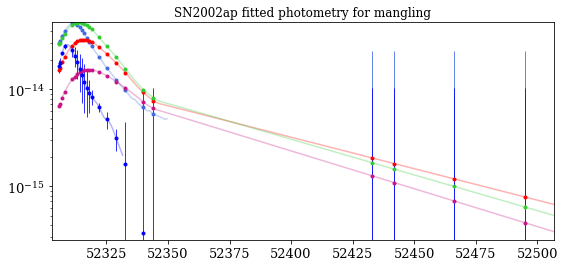

In [13]:
for sn in ['SN2012au', 'iPTF13bvn', 'SN2013am', 'SN2011ei', 'SN2002ap']:
    try:
        prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
        prova2.load()
        prova2.get_availfilter()
        prova2.clip_photometry()
        prova2.get_spec_mjd()
        prova2.LCfit_withGP()
        df = prova2.full_fitted_LC_file()
        cvs_file=prova2.mangling_GPfile()
        prova2.save_plot_GPfit()
        plt.show()
        prova2.save_plot_GPfit_spec()
        plt.show()
        #print_separate(prova2)
    except Exception as e:
        print (sn, e)
        

In [ ]:
#, SN2005cs, check SN2010al, SN2011dh Swift&Bessell_U flattens!!-->what?

In [ ]:
#def GP_fit(self, filt, new_mjd):

#filt = 'BessellB'
#new_mjd = np.arange(56430., 56560., 2.)
#
#LC_filt = prova2.get_singlefilter(filt)
#LC_filt_extended = extend_LC(LC_filt)
#
#mjd = np.atleast_2d(LC_filt_extended['MJD']).T
#norm = np.median(LC_filt_extended['flux']) 
#flux_norm = LC_filt_extended['flux']/norm
#err_flux_norm = LC_filt_extended['flux_err']/norm
#
#new_mjd_T = np.atleast_2d(new_mjd).T
#
#ExpSquaredKernel(500)

#kernel= C(1.0, (0.001, 10.)) * RBF(length_scale=35.0, length_scale_bounds=(20., 10000.)) \
#        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-2, 0.1))
#
#kernel= C(1.0, (0.001, 10.)) * ExpSineSquared(length_scale=35.0, length_scale_bounds=(20., 10000.)) \
#        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-2, 0.1))
#
##kernel= C(1.0, (0.001, 10.)) * ExpSineSquared(periodicity=500., periodicity_bounds=(200., 1000.0)) \
##        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-2, 0.1))
#
##kernel= Exponentiation(C, 500.)
#        #+ WhiteKernel(noise_level=1, noise_level_bounds=(1e-2, 0.1))
#
#n_opt=50
#
#gp2 = GaussianProcessRegressor(kernel=kernel, alpha=(err_flux_norm / flux_norm) ** 2, n_restarts_optimizer=n_opt)
#
#gp2.fit(mjd, flux_norm)
##self.gp_fit_module = gp
#
#flux_norm_pred, err_flux_norm_pred = gp2.predict(new_mjd_T, return_std=True)
#
#flux_pred = flux_norm_pred*norm
#err_flux_pred = err_flux_norm_pred*norm
#    
#return flux_pred, err_flux_pred



In [ ]:
no_spec=['SN2005db',
 'SN2005kd',
 'SN2006ca',
 'SN2006X',
 'SN2007av',
 'SN2007bf',
 'SN2007ct',
 'SN2007cu',
 'SN2007T',
 'SN2008aj',
 'SN2008B',
 'SN2008bj',
 'SN2008bx',
 'SN2009dd',
 'SN2010bq']

In [ ]:
color_dict = {'BessellU': 'blue',
              'BessellB': 'royalblue',
                'BessellV':  'limegreen',
                'BessellR':  'red',
                'BessellI':  'mediumvioletred',
                'SDSS_g':    'darkgreen',
                'SDSS_i':    'purple',
                'SDSS_r':    'darkred',
                'SDSS_z':    'sienna',
                'SDSS_u': 'darkblue',
                'swift_UVW1':'deepskyblue'}

In [ ]:
for sn in full_list:
    print (sn)
    if sn not in no_spec:
        prova2 = SNPhotometryClass(main_path=DATALC_PATH, snname=sn, verbose=True)
        cvs_file=prova2.mangling_GPfile()
        prova2.save_plot_GPfit()
        prova2.save_plot_GPfit_spec()

In [ ]:

for sn in Redshifts.keys():
    max_flux=[]
    prova2 = SNPhotometryClass(data_path=DATALC_PATH, snname=sn, verbose=True)
    print (prova2.get_availfilter())

    fig = plt.figure(figsize=(13,8))
    for f in prova2.get_availfilter():
        #fig = plt.figure(figsize=(10,3))
        mjd, logflux_norm, err_logflux_norm, logmu, logstd, logmu_obsmjd, logstd_obsmjd,\
            flux_norm, err_flux_norm, mu, std, mu_obsmjd, std_obsmjd, new_mjd = gp_fit(f)
        #plt.subplot(121)
        a=plt.errorbar(mjd, flux_norm, yerr= err_flux_norm, fmt='.', mfc=color_dict[f],
                       color=color_dict[f], linestyle='None', elinewidth=0.5)
        new_plot=plt.plot(new_mjd, mu, color=a[0].get_color(), lw=0.8, label=f)
        new_plot_filling=plt.fill_between(new_mjd, (mu+std), (mu-std), color=a[0].get_color(), alpha=0.1)
        plt.hlines(0, min(new_mjd), max(new_mjd))
        #plt.ylim(0.-1.2*min(flux_norm),max(flux_norm)*(1.2))
        plt.legend()
        #plt.subplot(122)
        #a=plt.errorbar(mjd, flux_norm-mu_obsmjd, fmt='o',label=f)
        #plt.fill_between(new_mjd, std, -std, color=a[0].get_color(), alpha=0.1)
        #plt.hlines(0, min(mjd), max(mjd))
        ##plt.ylim(-0.1,2.3)
        ##plt.xlim(56420, 56600)
        #plt.legend()
        #axes.append(new_plot)
        #axes_filling.append(new_plot_filling)
        max_flux.append(np.max(mu))
    plt.vlines(prova2.get_spec_mjd(), 10**-20, max_flux, lw=0.8, linestyle=':', color='k', label='Spectra')
    plt.xlim(min(prova2.phot_extended['MJD'])-7., max(prova2.get_spec_mjd())+30.)
    plt.legend(fontsize=11, loc='best', fancybox=True, framealpha=0.5)
    plt.title(prova2.snname)
    fig.savefig(prova2.data_path+'fittedGP3_%s_.pdf'%prova2.snname)
    plt.close(fig)



In [ ]:
prova2 = SNPhotometryClass(data_path=DATALC_PATH, snname='SN2013ge', verbose=True)
prova2.load()
for f in prova2.avail_filters:
    phot_f = prova2.get_singlefilter(f)
    a=plt.plot(phot_f['MJD'],\
         np.log10(phot_f['flux']), '.',label=f)

    mjd_peak = prova2.get_mjdpeak()
    filt_late = phot_f['MJD']>mjd_peak+60.
    try:
        m, q =np.polyfit(phot_f['MJD'][filt_late]-mjd_peak, np.log10(phot_f['flux'][filt_late]), 1)
        x= np.arange(60., 1000., 2.)
        plt.plot(x+mjd_peak, m*x+q, color=a[0].get_color(), linestyle='--')
        print f, m,q
    except TypeError:
        print 'no data'
plt.legend()
plt.plot(mjd_peak+60., np.median(np.log10(phot_f['flux'])), '^k')
plt.ylim()

plt.plot(x+mjd_peak, -0.0065*x+(-14.5), lw=5, color='k', alpha=0.3)

In [ ]:
prova2 = SNPhotometryClass(data_path=DATALC_PATH, snname='SN2002ap', verbose=True)
prova2.load()
for f in prova2.avail_filters:
    phot_f = prova2.get_singlefilter(f)
    a=plt.plot(phot_f['MJD'],\
         np.log10(phot_f['flux']), '.',label=f)

    mjd_peak = prova2.get_mjdpeak()
    filt_late = phot_f['MJD']>mjd_peak+60.
    try:
        m, q =np.polyfit(phot_f['MJD'][filt_late]-mjd_peak, np.log10(phot_f['flux'][filt_late]), 1)
        x= np.arange(60., 1000., 2.)
        plt.plot(x+mjd_peak, m*x+q, color=a[0].get_color(), linestyle='--')
        print f, m,q
    except TypeError:
        print 'no data'
plt.legend()
plt.plot(mjd_peak+60., np.median(np.log10(phot_f['flux'])), '^k')
plt.ylim()
plt.plot(x+mjd_peak, -0.0065*x+(-15), lw=5, color='k', alpha=0.3)

In [ ]:
prova2 = SNPhotometryClass(data_path=DATALC_PATH, snname='SN2007gr', verbose=True)
prova2.load()
for f in prova2.avail_filters:
    phot_f = prova2.get_singlefilter(f)
    a=plt.plot(phot_f['MJD'],\
         np.log10(phot_f['flux']), '.',label=f)

    mjd_peak = prova2.get_mjdpeak()
    filt_late = phot_f['MJD']>mjd_peak+60.
    try:
        m, q =np.polyfit(phot_f['MJD'][filt_late]-mjd_peak, np.log10(phot_f['flux'][filt_late]), 1)
        x= np.arange(60., 1000., 2.)
        plt.plot(x+mjd_peak, m*x+q, color=a[0].get_color(), linestyle='--')
        print f, m,q
    except TypeError:
        print 'no data'
plt.legend()
plt.plot(mjd_peak+60., np.median(np.log10(phot_f['flux'])), '^k')
plt.ylim()
plt.plot(x+mjd_peak, -0.0065*x+(-15), lw=5, color='k', alpha=0.3)

In [ ]:
prova2 = SNPhotometryClass(data_path=DATALC_PATH, snname='SN2011fu', verbose=True)
prova2.load()
for f in prova2.avail_filters:
    phot_f = prova2.get_singlefilter(f)
    a=plt.plot(phot_f['MJD'],\
         np.log10(phot_f['flux']), '.',label=f)

    mjd_peak = prova2.get_mjdpeak()
    filt_late = phot_f['MJD']>mjd_peak+60.
    try:
        m, q =np.polyfit(phot_f['MJD'][filt_late]-mjd_peak, np.log10(phot_f['flux'][filt_late]), 1)
        x= np.arange(60., 1000., 2.)
        plt.plot(x+mjd_peak, m*x+q, color=a[0].get_color(), linestyle='--')
        print f, m,q
    except TypeError:
        print 'no data'
plt.legend()
plt.plot(mjd_peak+60., np.median(np.log10(phot_f['flux'])), '^k')
plt.ylim()
plt.plot(x+mjd_peak, -0.0065*x+(-15), lw=5, color='k', alpha=0.3)

In [ ]:
#0.0065  330.

In [ ]:
y = my_gp.sample(size=100)

In [ ]:
plt.plot(mjd, flux_norm,'s',label=f)
a=plt.plot(mjd, y.T, lw=0.2, color='k')

In [ ]:
prova2 = SNPhotometryClass(data_path=DATALC_PATH, snname='SN1993J', verbose=True)

In [ ]:
LC_filt = prova2.get_singlefilter('BessellB')

In [ ]:
mjd_sorted = np.sort(LC_filt['MJD'])
flux_sorted = np.sort(LC_filt['flux'])
flux_err_sorted = np.sort(LC_filt['flux_err'])


In [ ]:
double = np.where(np.abs(mjd_sorted[:-1]-mjd_sorted[1:])<1.)

In [ ]:
double

In [ ]:
print LC_filt['MJD'][clipped_index], LC_filt['MJD'][clipped_index+1]
print LC_filt['flux'][clipped_index], LC_filt['flux'][clipped_index+1]
print LC_filt['flux_err'][clipped_index], LC_filt['flux_err'][clipped_index+1]

In [ ]:
def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, clipping_index):
    mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
    flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
    flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
    mjd_avg = np.average(mjd_tbc)
    flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
    flux_err_avg = np.sqrt(1./sum_w)
    clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
    clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
    clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
    clipped_mjd_sorted[clipping_index] = mjd_avg
    clipped_flux_sorted[clipping_index] = flux_avgX
    clipped_flux_err_sorted[clipping_index] = flux_err_avg
    print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
    return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted

In [ ]:
plt.errorbar(mjd_sorted, flux_sorted, yerr=flux_err_sorted)
plt.errorbar(new_mjd_sorted, new_flux_sorted, yerr=new_flux_err_sorted)

In [ ]:
def oldPhot(tgt, filt):#MJD_spec

    oldPhotometry = np.genfromtxt('/Users/mariavincenzi/PhD/SIM_pycoco/CoCo/recon/%s.dat'%tgt,\
                               dtype=None,encoding="utf-8")
    photo_filt = oldPhotometry['f3']==filt
    phot_MJD = (oldPhotometry['f0'][photo_filt])
    phot_flux = (oldPhotometry['f1'][photo_filt])
    phot_flux_err = (oldPhotometry['f2'][photo_filt])
    #if list(sorted(phot_MJD)) == list(phot_MJD):
    #    try: 
    #        closest_flux = np.argmin(np.abs(phot_MJD-(MJD_spec)))
    #        print ('flux', phot_flux[closest_flux])
    #        return phot_flux[closest_flux]
    #    except: return np.nan

In [ ]:
tgt='iPTF13bvn'
prova2 = SNPhotometryClass(main_path=DATALC_PATH, snname='iPTF13bvn', verbose=True)

prova2.LCfit_withGP()
oldPhotometry = np.genfromtxt('/Users/mariavincenzi/PhD/SIM_pycoco/CoCo/recon/%s.dat'%tgt,\
                               dtype=None,encoding="utf-8")

In [ ]:
fig = plt.figure(figsize=(8,5))
for f in prova2.avail_filters:
    c = color_dict[f]
    hc_mjd, hc_mu, hc_std = prova2.fitted_phot[f]['fit_highcadence'] 
    new_mjd, mu, std= prova2.fitted_phot[f]['fit_mjdspec'] 
    
    filt_index= oldPhotometry['f3']==f
    old_mjd, old_mu, old_std= oldPhotometry['f0'][filt_index], \
                                    oldPhotometry['f1'][filt_index],oldPhotometry['f2'][filt_index]


    #a=plt.errorbar(new_mjd, mu, yerr=std, fmt='.', mfc= c, \
    #       elinewidth=0.8, color= c,linestyle='None')
    a=plt.errorbar(old_mjd, old_mu, yerr=old_std, fmt='.', mfc= c, \
           elinewidth=0.8, color=c, linestyle='None')

    plt.plot(hc_mjd, hc_mu, color=a[0].get_color(), label=f, alpha=0.3)

plt.hlines(0, min(new_mjd)-7., max(new_mjd))
plt.vlines(prova2.get_spec_mjd(), 10**-20, 10**-15, lw=0.8, linestyle=':', color='k', label='Spectra')
plt.xlim(min(prova2.phot_extended['MJD'])-7., max(prova2.get_spec_mjd())+15.)
plt.legend(fontsize=11, loc='best', fancybox=True, framealpha=0.5)
plt.title(prova2.snname+' fitted photometry for mangling')


In [ ]:
prova2.save_plot_GPfit_spec()